In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

Будем анализировать распределение показаний вольтметра 
при прохождении большого тока через металлический резистор. "Большой ток" - в том смысле, что нагрев резитора уменьшает его сопротивление и, за счет этого, ток возрастает нелинейно. 

$$ {I} = \frac {{U}} {{R} * (1 - \alpha T)} $$

Однако т.к. влияние температуры мало, закон Ома по-прежнему выполняется с досточноной точностью для применения линейной аппроксимации.





In [2]:
n_samples = 1000

temp = np.random.choice(100, n_samples)
voltage = np.random.choice(120, n_samples) + 15
resistance = np.random.choice(80, n_samples) + 10

current = voltage / resistance * (1 - temp*1e-6) * 1000

data = pd.DataFrame({'temp': temp, 'voltage': voltage, 'resistance': resistance, 'current': current})
data.head(5)

,temp,voltage,resistance,current
0,25,81,46,1760.825543
1,3,103,24,4291.653792
2,25,101,73,1383.527055
3,80,95,24,3958.016667
4,50,74,88,840.867045


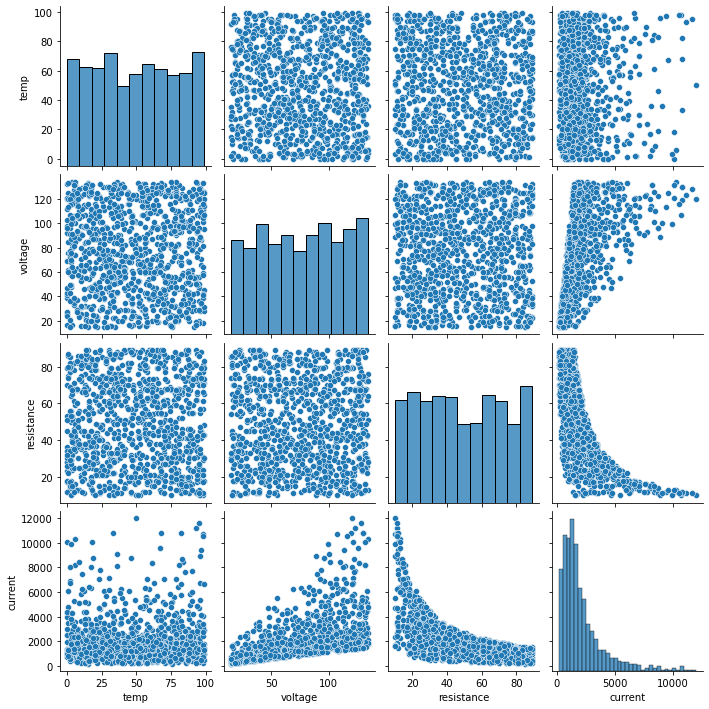

In [3]:
sns.pairplot( data )

Теперь забываем, как мы готовили dataset и пытаемся построить модель.

Видно из графиков pairplot, что current зависит как-то непонятно от temp.  
К счастью, зависимость от temp похоже слабая, т.к. точки разбросаны почти по всему графику.  
Скорее всего, зависимость от temp можно игнорировать (по крайней мере для начала).

Понятно как зависит current от voltage - скорее всего линейно.  
А вот как current зависит от resistance - неясно. Какая-то убывающая зависимость.  

In [4]:
from sklearn.metrics import mean_absolute_error

X = data[['temp', 'voltage', 'resistance']]
y = data['current']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['temp', 'voltage', 'resistance']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [  0.94563223  28.13683799 -53.46626075]
Bias: 2583.8788644147535
Error: 724.7333941823075


In [5]:
y.median()

1599.8799999999999

Простая линейная аппроксимация дает ошибку того же порядка, что и медиана.  
Значит линейная аппроксимация не удовлетворительно описывает данные.

In [6]:
X = data[['voltage', 'resistance']]
y = data['current']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['voltage', 'resistance']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [ 28.12007102 -53.47572491]
Bias: 2632.011706900634
Error: 724.0849327663122


Исключение слабо влияющего параметра temp не помогло - ошибка по-прежнему большая.

In [7]:
# Создаем новые признаки наугад
data['div'] = data['voltage'] / data['resistance']
data['exp'] = data['voltage'] * np.exp( - data['resistance'] )
data.head(5)

,temp,voltage,resistance,current,div,exp
0,25,81,46,1760.825543,1.760870,8.529800e-19
1,3,103,24,4291.653792,4.291667,3.888389e-09
2,25,101,73,1383.527055,1.383562,1.999052e-30
3,80,95,24,3958.016667,3.958333,3.586378e-09
4,50,74,88,840.867045,0.840909,4.480405e-37


In [8]:
X = data[['exp']]
y = data['current']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['exp']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [2539784.16645773]
Bias: 2013.9967273651919
Error: 1209.94727463662


При экспоненциальной зависимости ошибка не уменьшилась - порядок значений тот же, что у среднего значение величины

In [9]:
X = data[['div']]
y = data['current']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['div']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [999.94802386]
Bias: 0.005786110443295911
Error: 0.05778841309947748


А вот при делении на resistance ошибка сильно падает.  
Явно нужно дальше улучшать модель, исходя из предположение, что resistance где-то в знаменателе